1. tf.load로 tf_flower 데이터 다운받기


2. 이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches를 준비합니다.

3. 모델 설계
모델은 어떤 방식으로 설계하고 싶은가요? 나만의 모델을 만들 것인가요, 아니면 base_model을 활용할 것인가요?
원하는 방식으로 모델을 만들어 보세요!
cats_vs_dogs 의 경우와 달리, tf_flowers 데이터셋에서는 class의 갯수가 5가지입니다. 모델 설계시 어느 부분이 달라질지에 유의해 주세요.


4. 모델 학습시키기
모델을 학습시켜봅니다. 단, 여기에서는 여러 가지 옵션을 바꿔볼 수 있습니다.
예를 들어, 모델 학습을 10 epoch보다 더 많이 시켜보거나, learning_rate 값을 바꿔볼 수 있습니다.
또는, optimizer의 종류도 바꿔볼 수 있습니다. 바꿔보고 싶다면, 여기를 참고하세요.
어쩌면 VGG16이 아닌 다른 모델을 base model로 활용할 수도 있을 것입니다. 그리고 파인튜닝을 fc layer의 구성에 변화를 줄 수 있을지도 모릅니다.
이전 스텝에서는 시도하지 않았던 Regularization 기법이 적용된다면 어떨까요? Dropout이나 Batch Normalization을 적용하는 것은 그리 어려운 일이 아닙니다.

5. 모델 성능 평가
모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.
모델이 학습된 과정을 그래프로도 그려보고, validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 보세요!

6. 모델 활용하기
모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.
원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!


In [2]:
#필요한 경고메시지만 출력하기
import warnings
warnings.filterwarnings("ignore")

'''
pip install pillow
$ pip install tensorflow_datasets
'''

import tensorflow_datasets as tfds
import tensorflow as tf


### 1. tfds.load로 'tf_flowers' 다운받기

3670 데이터
IMAGE = ( , , 3) (color)
label = 5 classes

In [3]:

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

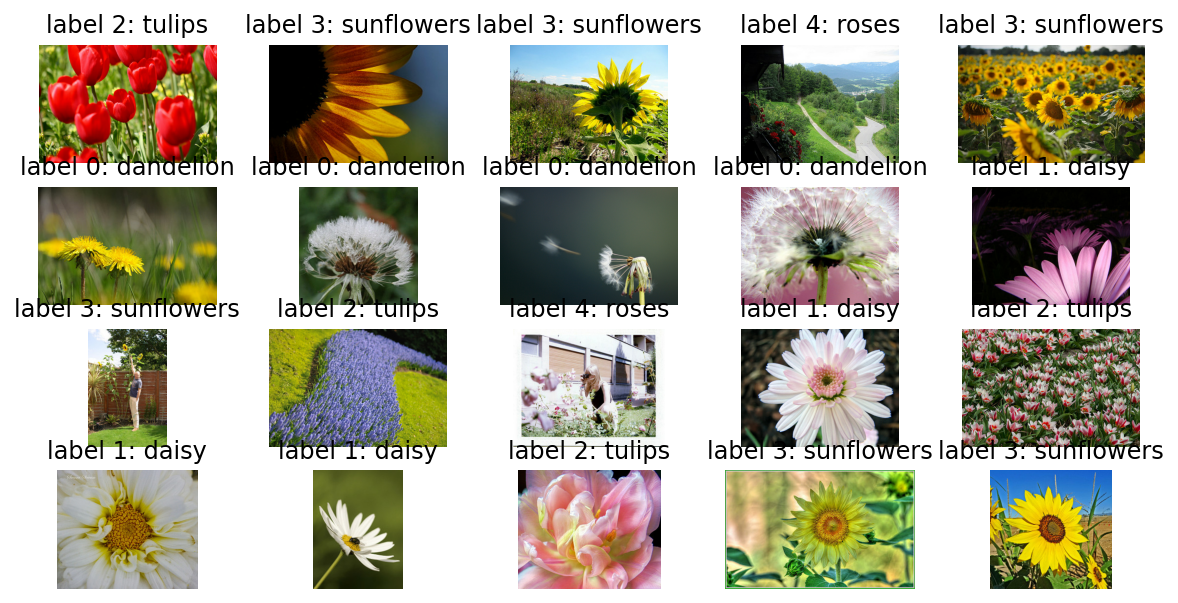

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(20)):
    plt.subplot(4, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 2. 이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches를 준비합니다.

In [5]:
#이미지 사이즈 조정하기
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

#Train, Validation, Test 셋에 적용해서 변경
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

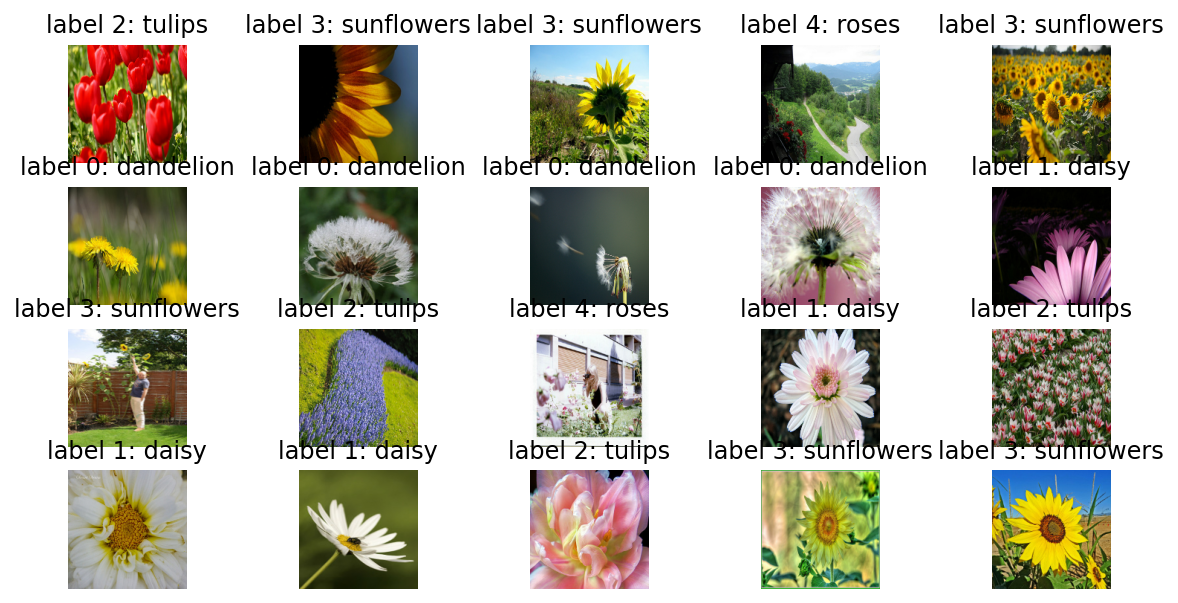

In [6]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(20)):
    plt.subplot(4, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 3. 모델 설계

 - 원하는 방식으로 모델을 만들기


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

### 모델 직접 설계하기

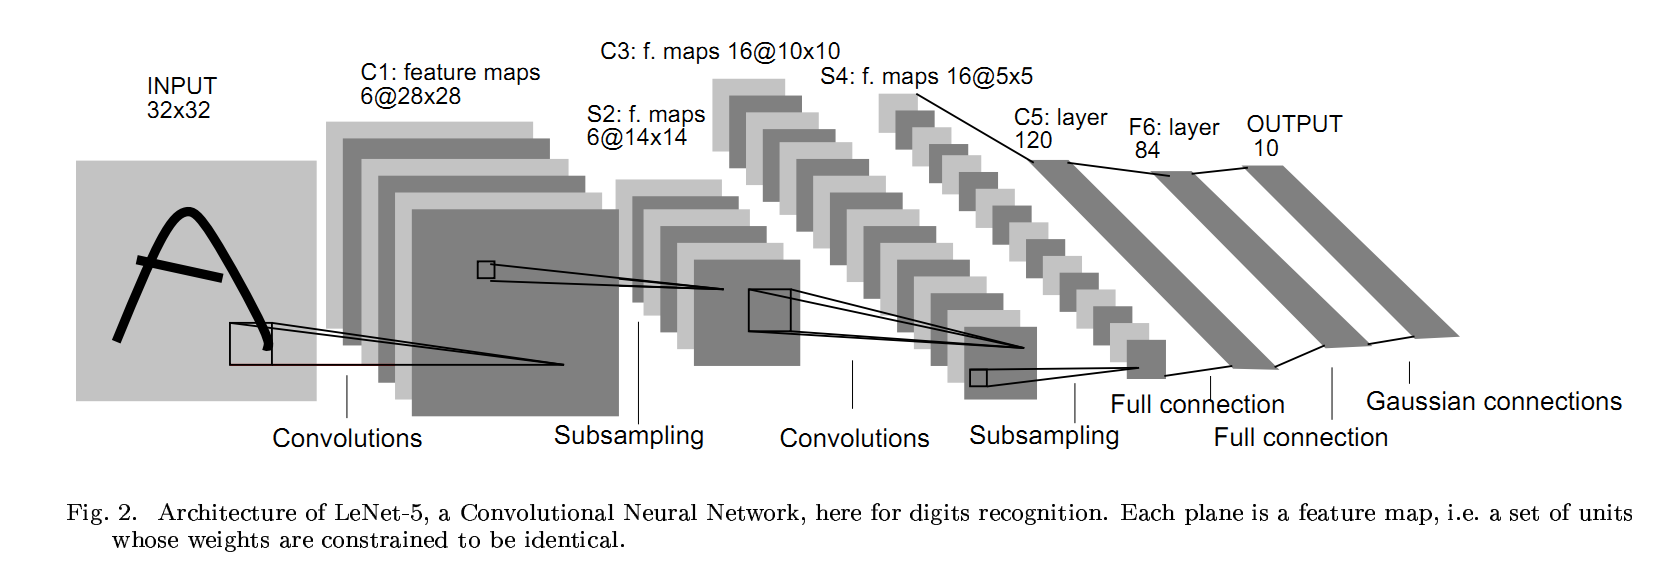


In [11]:
model_self = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])
model_self.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

- Model compile하기 위해서 세가지가 필요함.

 1. optimizer =  어떤 방식으로 학습시킬지 결정.  최적화 시킬지 정함.(Loss 를 줄이는 방법) 그래서 최적화 함수라고 부르기도 함.
 
 2. Loss = 모델이 학습해나가야하는 방향을 결정. 각 Label에 가깝도록 방향 제시
 
 3. Metrics = 모델의 성능평가 척도.

In [12]:
base_learning_rate = 0.00001
model_self.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

 - Batch size  : 한 스텝에 학습시킬 데이터 개수
 - Shiffer buffer size : 학습 데이터를 적절히 섞어줄 파라미터

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 200

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [15]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

### 학습 전에 모델의 성능을 평가해보자.

 - 약 16프로로 매우 낮음.

In [16]:
validation_steps = 20
loss0, accuracy0 = model_self.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

12/20 [=================>............] - ETA: 1s - loss: 1.6554 - accuracy: 0.1635WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


12/20 [=================>............] - 3s 247ms/step - loss: 1.6554 - accuracy: 0.1635
initial loss: 1.66
initial accuracy: 0.16


### 4.모델 학습 시키기.

In [17]:
EPOCHS = 10
history = model_self.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 21s 231ms/step - loss: 1.4218 - accuracy: 0.4040 - val_loss: 1.3172 - val_accuracy: 0.4496
Epoch 2/10
92/92 [==============================] - 12s 127ms/step - loss: 1.2282 - accuracy: 0.5065 - val_loss: 1.1728 - val_accuracy: 0.5313
Epoch 3/10
92/92 [==============================] - 12s 128ms/step - loss: 1.1374 - accuracy: 0.5399 - val_loss: 1.1277 - val_accuracy: 0.5586
Epoch 4/10
92/92 [==============================] - 11s 123ms/step - loss: 1.0846 - accuracy: 0.5756 - val_loss: 1.0996 - val_accuracy: 0.5531
Epoch 5/10
92/92 [==============================] - 11s 117ms/step - loss: 1.0390 - accuracy: 0.5981 - val_loss: 1.0763 - val_accuracy: 0.5640
Epoch 6/10
92/92 [==============================] - 12s 135ms/step - loss: 1.0039 - accuracy: 0.6172 - val_loss: 1.0502 - val_accuracy: 0.5858
Epoch 7/10
92/92 [==============================] - 9s 101ms/step - loss: 0.9716 - accuracy: 0.6281 - val_loss: 1.0460 - val_accuracy: 0.5913


### 기본 CNN 모델로 학습시킨 결과, 정확도가 68%가 나왔다. 나쁘다..

### 5. 모델성능 평가 해보기

학습된 과정을 그래프로 그리고, test,validation batches에 있는 데이터 예측 결과 확인해보자

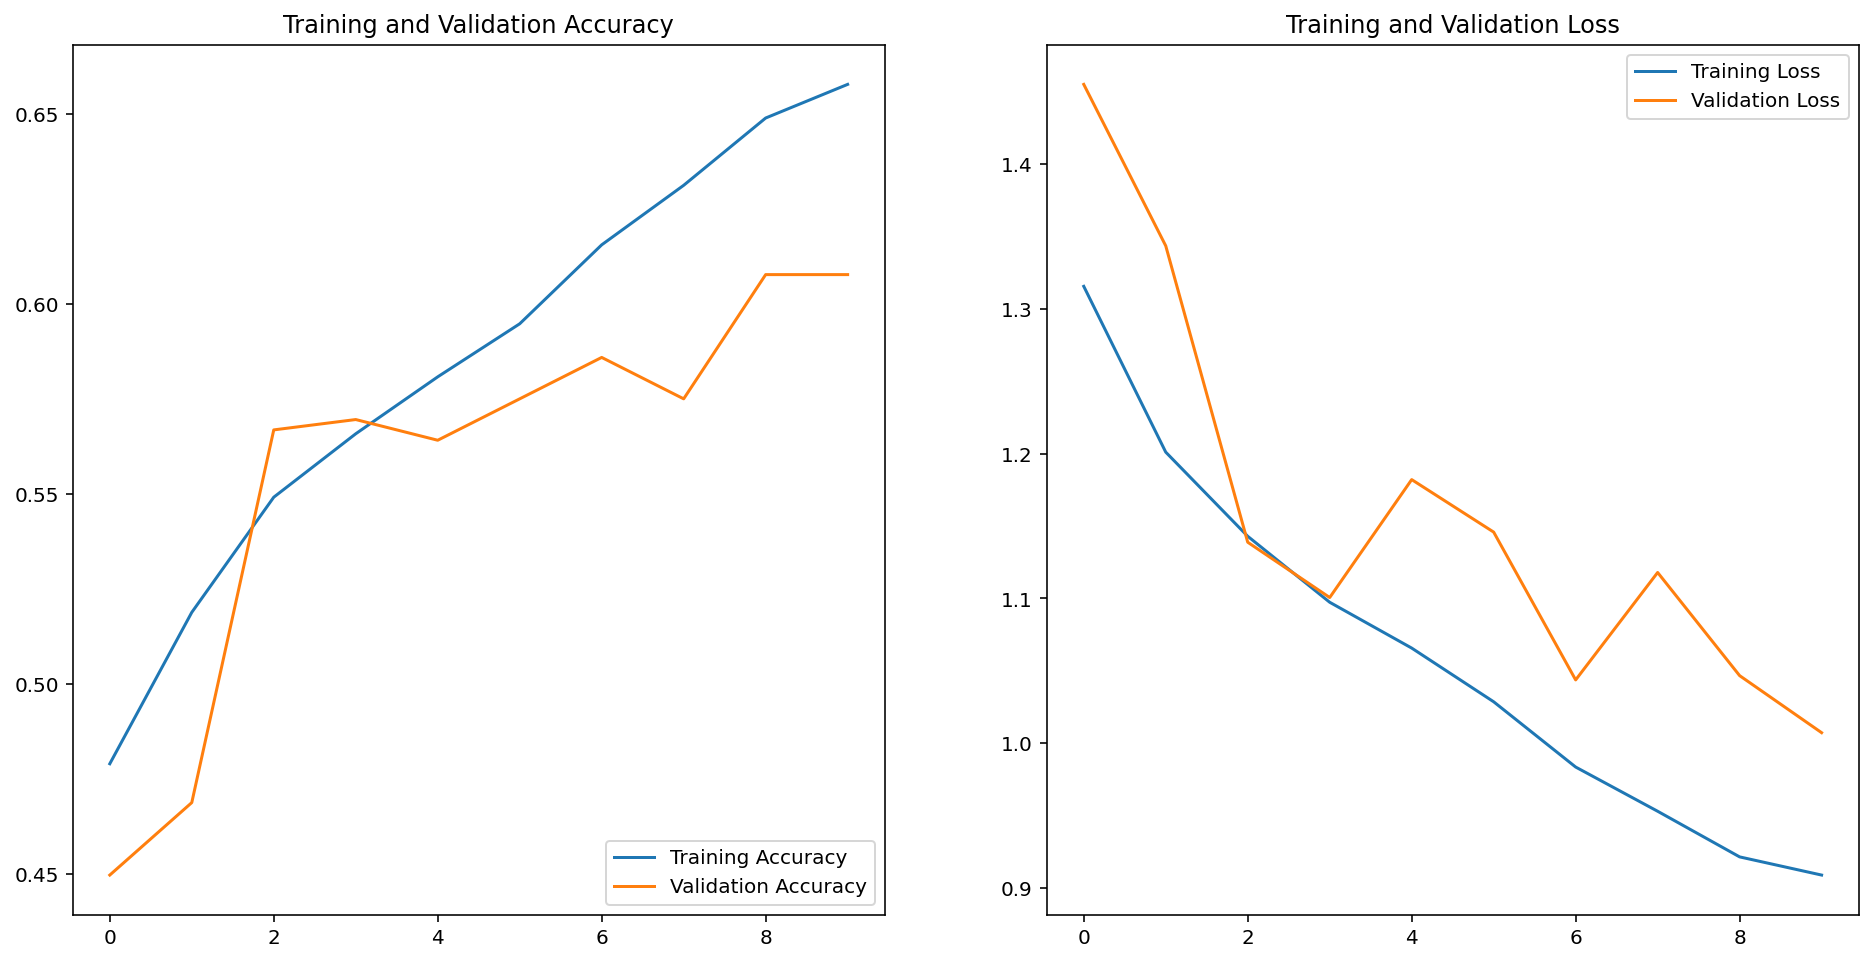

In [265]:
history_first=history
acc = history_first.history['accuracy']
val_acc = history_first.history['val_accuracy']

loss=history_first.history['loss']
val_loss=history_first.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

epoch 를 20으로 올리면 더 성능이 좋아질 것 같다.


In [18]:
EPOCHS = 20
history_2 = model_self.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 9s 100ms/step - loss: 0.8680 - accuracy: 0.6730 - val_loss: 1.0047 - val_accuracy: 0.5777
Epoch 2/20
92/92 [==============================] - 9s 100ms/step - loss: 0.8418 - accuracy: 0.6843 - val_loss: 0.9965 - val_accuracy: 0.6076
Epoch 3/20
92/92 [==============================] - 9s 100ms/step - loss: 0.8212 - accuracy: 0.7047 - val_loss: 0.9532 - val_accuracy: 0.6322
Epoch 4/20
92/92 [==============================] - 11s 118ms/step - loss: 0.8007 - accuracy: 0.7112 - val_loss: 0.9487 - val_accuracy: 0.6567
Epoch 5/20
92/92 [==============================] - 9s 100ms/step - loss: 0.7804 - accuracy: 0.7207 - val_loss: 0.9553 - val_accuracy: 0.6567
Epoch 6/20
92/92 [==============================] - 12s 128ms/step - loss: 0.7624 - accuracy: 0.7272 - val_loss: 0.9898 - val_accuracy: 0.6131
Epoch 7/20
92/92 [==============================] - 11s 116ms/step - loss: 0.7447 - accuracy: 0.7374 - val_loss: 0.9531 - val_accuracy: 0.6349
Epo

KeyboardInterrupt: 

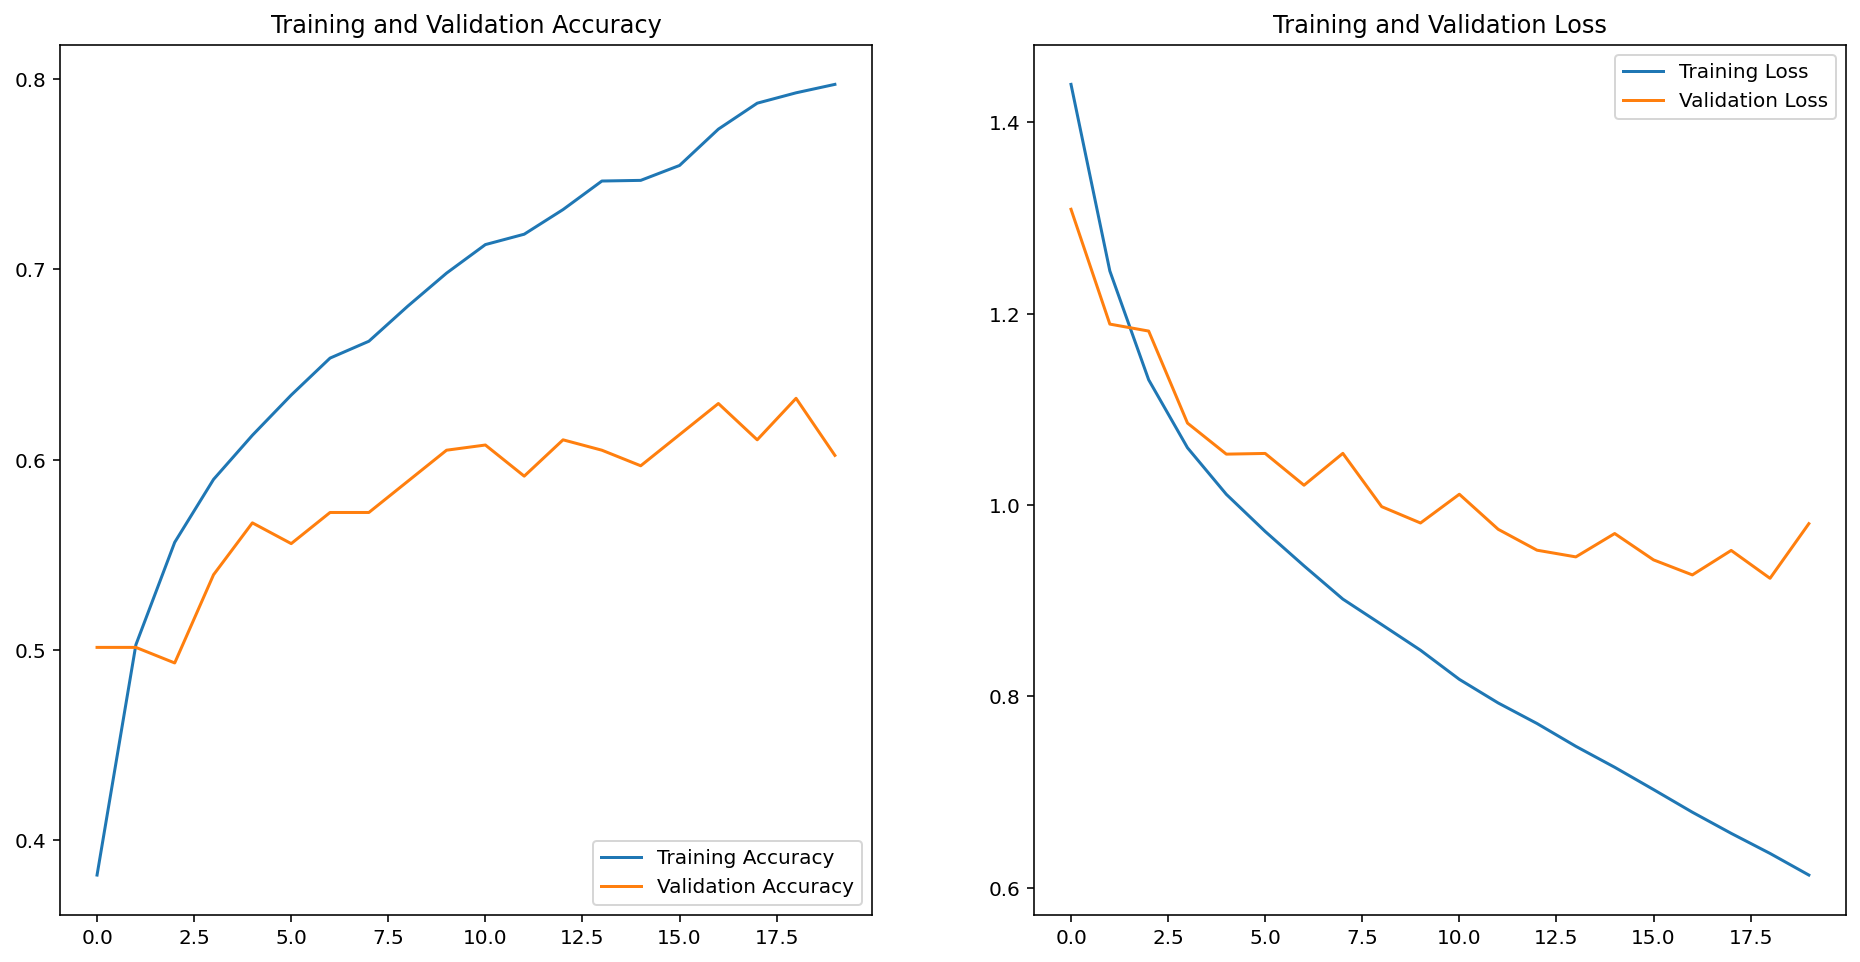

In [267]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss=history_2.history['loss']
val_loss=history_2.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 예상과는 다르게, Validation Set의 정확도와 로스 모두 나아지지 않았다. 오히려 나빠졌다..

 - learning rate를 바꿔보자 : 0.00001 -> 0.000003
 --> 효과가 별로 없다.
 
 - TRAIN ACCUCARY는 92%, Val_Loss가 증가하는걸 봐서 오버피팅이 됐다고 볼 수 있다.

In [ ]:

base_learning_rate = 0.00003
model_self.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
EPOCHS = 20
history_2 = model_self.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [270]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model_self.predict(image_batch)
    pass

import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 4, 0, 1, 2, 0, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 0, 4, 2, 0,
       1, 0, 0, 0, 0, 2])

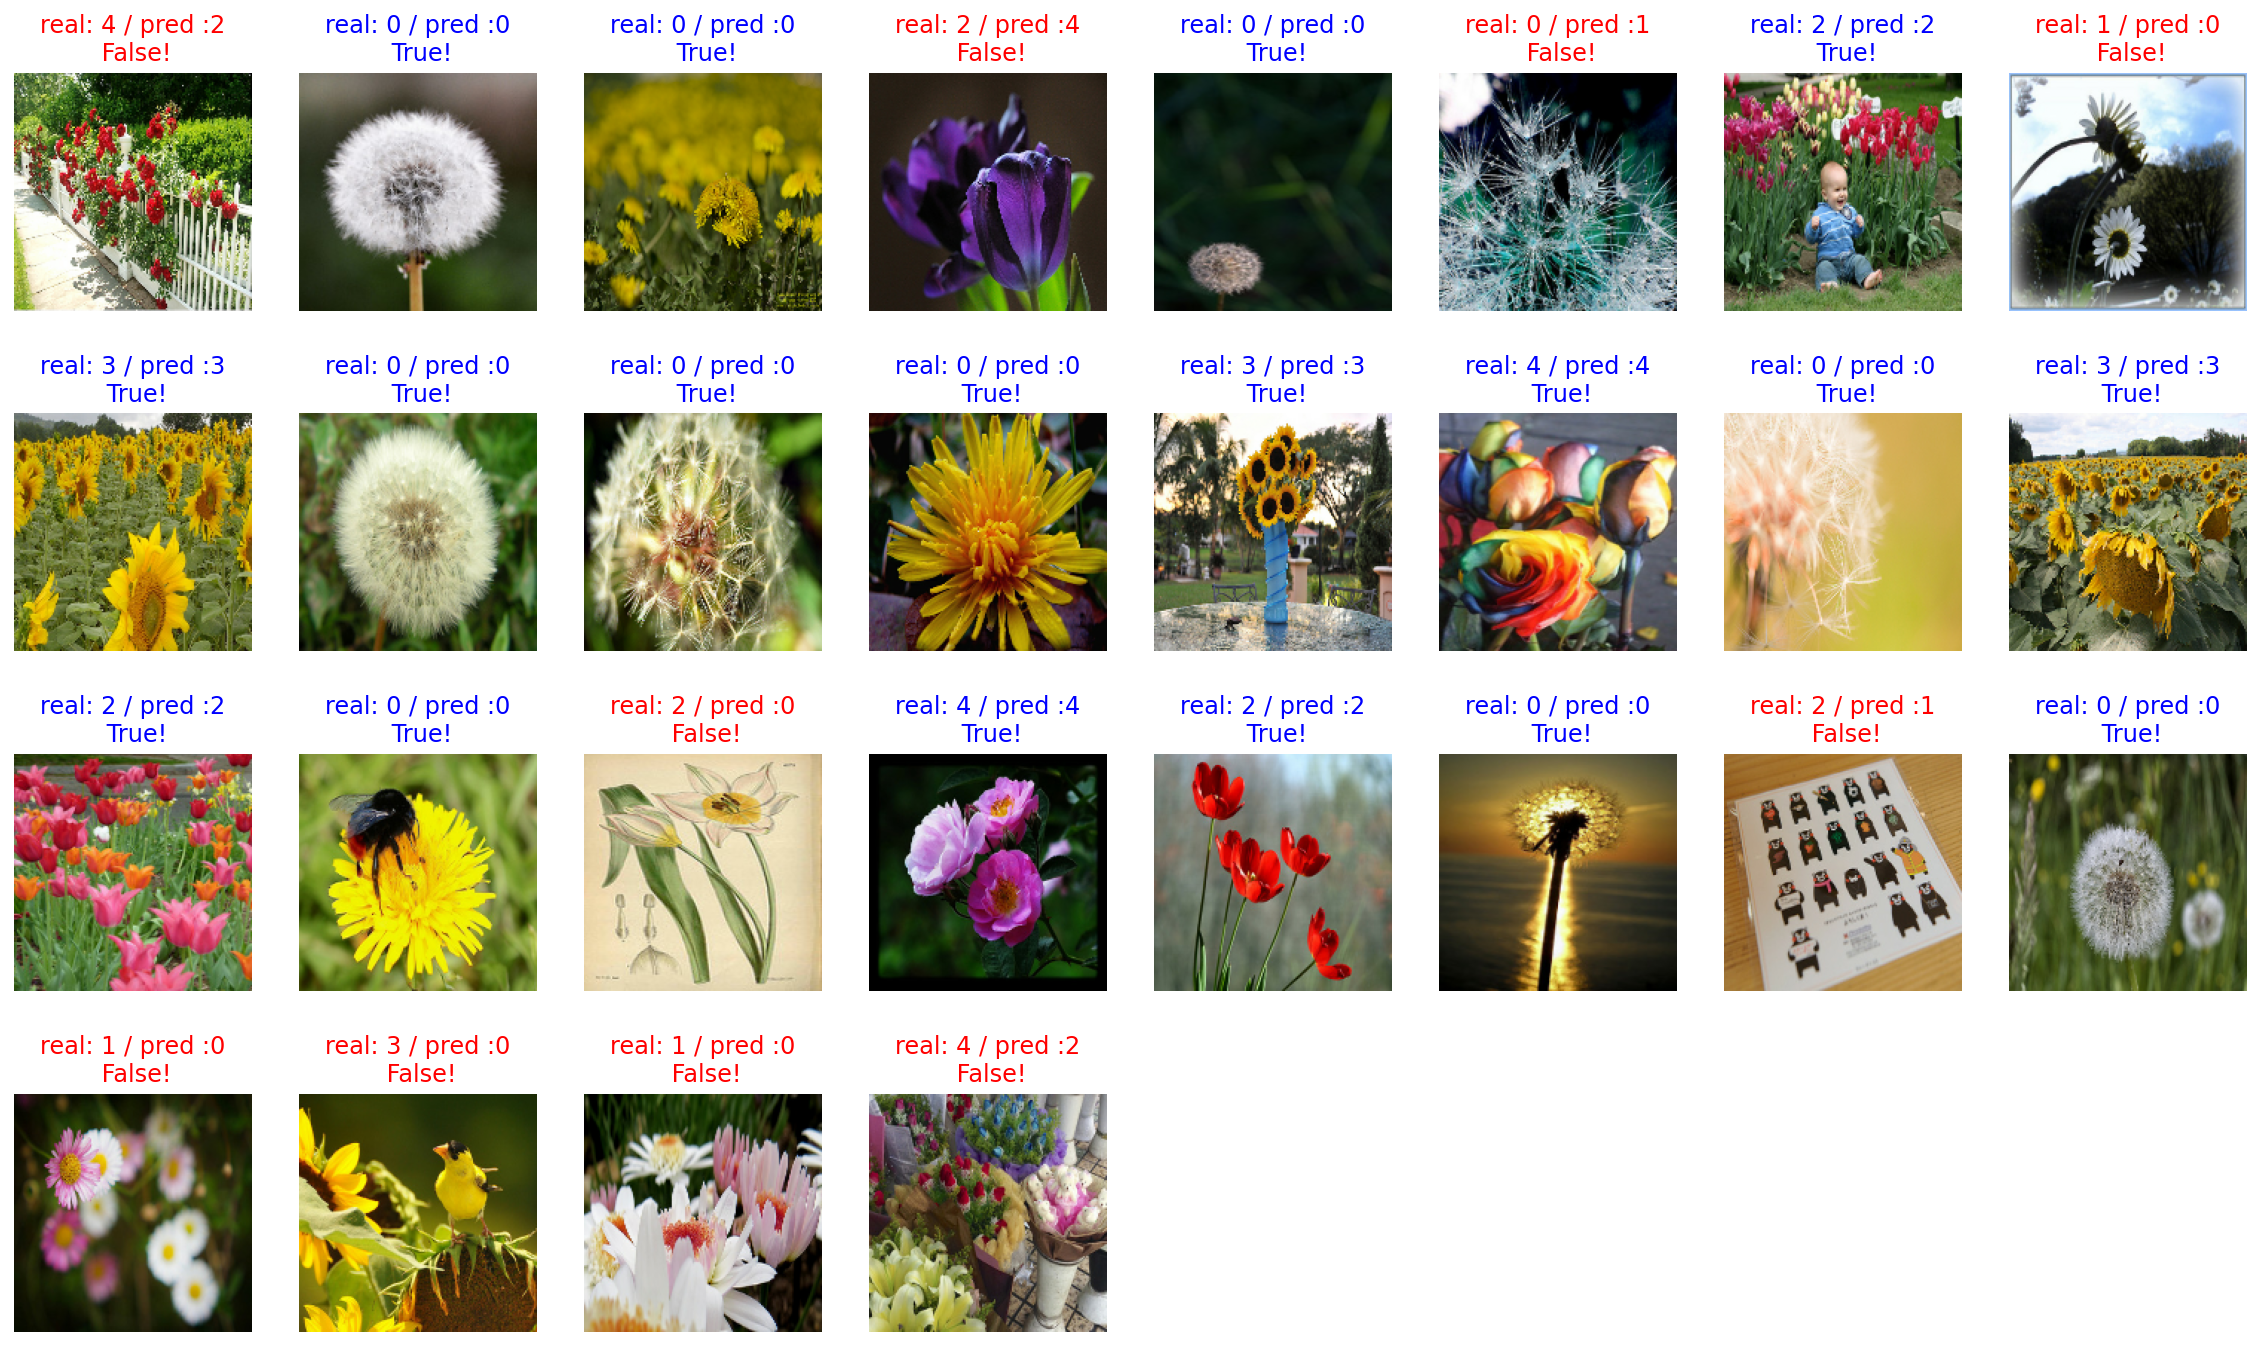

In [271]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

### 6. 내 모델 직접 설계하기

##### ResNet50 모델 가져오기


In [ ]:
#Train, Validation, Test 셋에 적용해서 변경
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(160,160,3)
                                            )
                                            

In [ ]:
base_model.summary()

In [351]:

feature_batch=base_model(image_batch)
feature_batch.shape

TensorShape([28, 5, 5, 2048])

 -  CNN에서는 마지막 레이어에서 Flatten을 사용해서 feature을 일직선으로 만들었었다.
 
 *  이번에는 Global Average Pooling을 사용해 보겠다.
 Gloabal average pooling 후에는 (1,1,Depth)로 바뀐다.
 
 - 참고 : https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/2d-global-average-pooling

In [352]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(dense_layer(feature_batch_average)) 
print(prediction_batch.shape)

(28, 2048)
(28, 5)


In [353]:
#base모델 학습시키기 
#base_model.trainable = False Classifier 만 학습시킬때
base_model.trainable = True
#N_Freeze 번까지는 학습 안시키고, 그 뒤에는 학습시키기

N_FREEZE = 120
for layer in base_model.layers[:N_FREEZE]:
    layer.trainable = False


#최종 모델
model_resnet50 = tf.keras.Sequential([
  base_model,
  global_average_layer,
    dense_layer,
  prediction_layer
])

model_resnet50.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_30  (None, 2048)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 24,576,773
Non-trainable params: 62,592
_________________________________________________________________


In [354]:
resnet50_learning_rate = 0.00001
model_resnet50.compile(optimizer=tf.keras.optimizers.RMSprop(lr=resnet50_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

EPOCHS = 20 

history = model_resnet50.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
105/105 [==============================] - 15s 142ms/step - loss: 1.0925 - accuracy: 0.6025 - val_loss: 1.6400 - val_accuracy: 0.2480
Epoch 2/20
105/105 [==============================] - 15s 143ms/step - loss: 0.4619 - accuracy: 0.8600 - val_loss: 1.5625 - val_accuracy: 0.3597
Epoch 3/20
105/105 [==============================] - 14s 137ms/step - loss: 0.2471 - accuracy: 0.9387 - val_loss: 1.4682 - val_accuracy: 0.3706
Epoch 4/20
105/105 [==============================] - 15s 143ms/step - loss: 0.1336 - accuracy: 0.9714 - val_loss: 1.2521 - val_accuracy: 0.4959
Epoch 5/20
105/105 [==============================] - 15s 138ms/step - loss: 0.0715 - accuracy: 0.9891 - val_loss: 0.9276 - val_accuracy: 0.6649
Epoch 6/20
105/105 [==============================] - 15s 138ms/step - loss: 0.0376 - accuracy: 0.9935 - val_loss: 0.6228 - val_accuracy: 0.7820
Epoch 7/20
105/105 [==============================] - 14s 137ms/step - loss: 0.0204 - accuracy: 0.9976 - val_loss: 0.4711 - val_ac

1. DATASET은 3670개, 5개 클래스이기 때문에 굉장히 작다고 볼 수 있다. ==> 따라서 Transfer Learning 중 2,3 번 전략이 좋다고 생각함
   -  참고 Tranfer Learning : https://jeinalog.tistory.com/13       
   

3. 3번 전략(Classifer만 학습)은 결과가 좋지 않았다.
-Imagenet 의 데이터셋의 카테고리를 본 결과, 1000개의 카테고리 중에 꽃과 관련된 카테고리는 매우 적었다. 따라서 Classifier만 학습시킨것이 의미가 없다고 생각하여 2번 전략(모델의 일부만 학습시키는것)을 쓰기로 했다.


4. N_FREEZE (Base model의 몇번째 Layer부터 학습시킬건지 나타내는 prameter)를 100->5로 줄여나가며 학습을 진행해 보았다. 
### val-Accuracy가 거의 90%까지 좋아지는 것을 확인할 수 있었다.

### N_FREEZE 가 100 : 100번째 이후의 layer부터 학습을 하겠다. ==>  기존의 Imagenet으로 학습한 데이터이기 때문에, 1000개의 데이터에 대한 정보를 100 layer이후부터 현재의 꽃데이터에 적용하겠다

### N_FREEZE 가 5 : 5번째 이후의 layer부터 학습을 하겠다. ==>  5 layer까지 뽑은 정보를 이후에는 모두 꽃 데이터를 분류하는데 사용하겠다.

따라서 N_FREEZE가 낮으면 좋은 성능을 냈다고 생각했다.


### 아래에는 DenseNet169 모델을 불러와서 Classifer만 학습하고 측정해보았다.

### 위의 Resnet50 보다 훨씬 더 좋은 성능을 가지고 있다...

In [27]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

base_model = tf.keras.applications.DenseNet169(include_top=False,
                                            weights='imagenet',
                                            input_shape=(160,160,3)
                                            )

In [28]:
feature_batch=base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
    dense_layer,
  prediction_layer
])

model.summary()

learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

EPOCHS = 10 

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1664)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               852480    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 2565      
Total params: 13,497,925
Trainable params: 855,045
Non-trainable params: 12,642,880
_________________________________________________________________
Epoch 1/10
92/92 [==============================] - 23s 247ms/step - loss: 0.7873 - accuracy: 0.7248 - val_loss: 0.4970 - val_accuracy: 0.8202
Epoch 2/10
92/92 [==============================] - 21s 229ms/step - loss: 0.3456 - accurac